# Requirements

In [1]:
# Add as many imports as you need.import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from docutils.nodes import label
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xarray.util.generate_ops import inplace
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Add as many imports as you need.

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **close price** for the Amazon stock. To accomplish this, you will use data from the preceding 7 days, and past statistics. 


## The Amazon Stock Price Dataset

The dataset comprises the following columns:
- date - the date of the recorded price
- open - the open price of the stock
- high - the high price of the stock
- low - the low price of the stock
- volume - the volume trades
- close - the close price of the stock

Target:
close

Load the dataset into a `pandas` data frame.

In [2]:
# Write your code here. Add as many boxes as you need.
data = pd.read_csv("amazon_stock_price.csv")
data

,date,open,high,low,close,volume
0,1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000
1,1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000
2,1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000
3,1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000
4,1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000
...,...,...,...,...,...,...
6680,2023-11-30,144.7600,146.9300,144.3300,146.0900,65814000
6681,2023-12-01,146.0000,147.2500,145.5500,147.0300,39924600
6682,2023-12-04,145.2500,145.3500,142.8100,144.8400,48294200
6683,2023-12-05,143.5500,148.5700,143.1300,146.8800,46822400


Explore the dataset using visualizations of your choice.

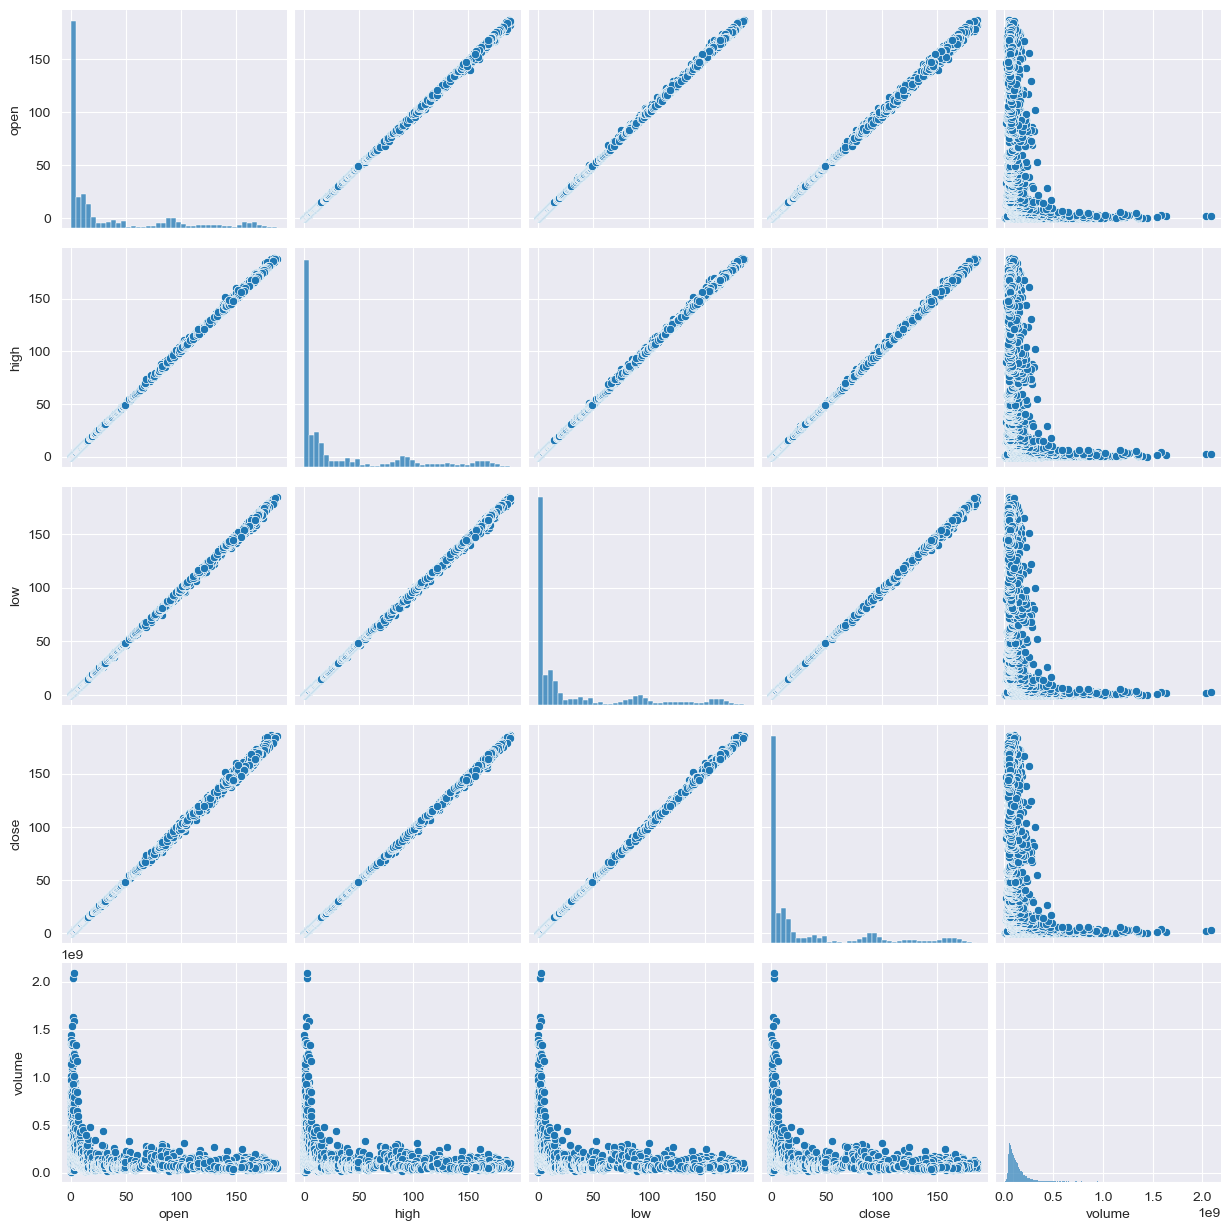

In [3]:
# Write your code here. Add as many boxes as you need.
sns.pairplot(data)

# Feauture Extraction
Select the relevant features for prediction and apply a lag of up to 7 days to each chosen feature

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [4]:
# Write your code here. Add as many boxes as you need.
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6685 entries, 1997-05-15 to 2023-12-06
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6685 non-null   float64
 1   high    6685 non-null   float64
 2   low     6685 non-null   float64
 3   close   6685 non-null   float64
 4   volume  6685 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 313.4 KB


In [6]:
for i in range(1, 8):
    data[f'open_lag_{i}']  = data['open'].shift(i)
    data[f'high_lag_{i}']  = data['high'].shift(i)
    data[f'low_lag_{i}']  = data['low'].shift(i)
    data[f'close_lag_{i}']  = data['close'].shift(i)
    data[f'volume_lag_{i}']  = data['volume'].shift(i)
data.drop(columns=['open','high','low','volume'],inplace=True)
data = data.dropna(axis=0)
data

,open,high,low,close,volume,open_lag_1,high_lag_1,low_lag_1,close_lag_1,volume_lag_1,...,open_lag_6,high_lag_6,low_lag_6,close_lag_6,volume_lag_6,open_lag_7,high_lag_7,low_lag_7,close_lag_7,volume_lag_7
date,,,,,,,,,,,,,,,,,,,,,
1997-05-27,0.0755,0.0823,0.0729,0.0792,173952000,0.0703,0.0760,0.0667,0.0750,318744000.0,...,0.0984,0.0990,0.0854,0.0865,294000000.0,0.1219,0.1250,0.0964,0.0979,1.443120e+09
1997-05-28,0.0812,0.0818,0.0766,0.0766,91488000,0.0755,0.0823,0.0729,0.0792,173952000.0,...,0.0880,0.0885,0.0812,0.0854,122136000.0,0.0984,0.0990,0.0854,0.0865,2.940000e+08
1997-05-29,0.0771,0.0771,0.0740,0.0753,69456000,0.0812,0.0818,0.0766,0.0766,91488000.0,...,0.0865,0.0875,0.0818,0.0818,109344000.0,0.0880,0.0885,0.0812,0.0854,1.221360e+08
1997-05-30,0.0750,0.0755,0.0740,0.0750,51888000,0.0771,0.0771,0.0740,0.0753,69456000.0,...,0.0818,0.0823,0.0688,0.0714,377064000.0,0.0865,0.0875,0.0818,0.0818,1.093440e+08
1997-06-02,0.0755,0.0766,0.0750,0.0755,11832000,0.0750,0.0755,0.0740,0.0750,51888000.0,...,0.0719,0.0724,0.0656,0.0698,235536000.0,0.0818,0.0823,0.0688,0.0714,3.770640e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,144.7600,146.9300,144.3300,146.0900,65814000,147.8500,148.5400,145.9700,146.3200,40610900.0,...,143.9100,144.0500,141.5000,143.9000,71226000.0,145.1300,146.6300,144.7300,146.1300,4.195120e+07
2023-12-01,146.0000,147.2500,145.5500,147.0300,39924600,144.7600,146.9300,144.3300,146.0900,65814000.0,...,144.5700,147.7400,144.5700,146.7100,45669100.0,143.9100,144.0500,141.5000,143.9000,7.122600e+07
2023-12-04,145.2500,145.3500,142.8100,144.8400,48294200,146.0000,147.2500,145.5500,147.0300,39924600.0,...,146.7000,147.2000,145.3200,146.7400,22378400.0,144.5700,147.7400,144.5700,146.7100,4.566910e+07


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [7]:
# Write your code here. Add as many boxes as you need.
X = data.drop(columns='close')
Y = data['close']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0,shuffle=False)

## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [8]:
# Write your code here. Add as many boxes as you need.
model = RandomForestRegressor()
model.fit(X_train, Y_train)

RandomForestRegressor()

Use the trained model to make predictions for the test set.

In [9]:
# Write your code here. Add as many boxes as you need.
y_pred = model.predict(X_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [10]:
# Write your code here. Add as many boxes as you need.
rfr_mse = mean_squared_error(Y_test, y_pred)
rfr_mae = mean_absolute_error(Y_test, y_pred)
rfr_r2 = r2_score(Y_test, y_pred)
print(f'Random Forest\n')
print(f'MSE: {rfr_mse}')
print(f'MAE: {rfr_mae}')
print(f'R2 : {rfr_r2}')

Random Forest

MSE: 1867.2800968522472
MAE: 31.76331004865266
R2 : -0.8353158849900011


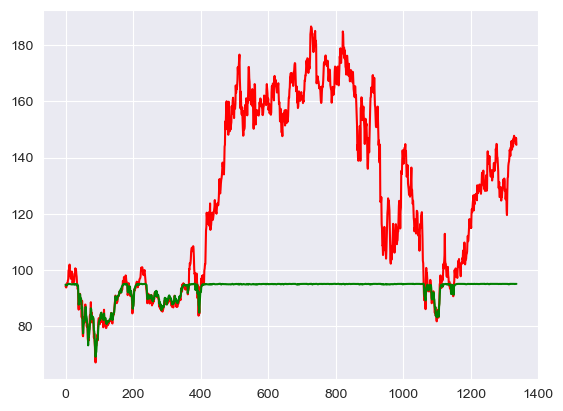

In [11]:
plt.plot(Y_test.values, label='Actual', color='red')
plt.plot(y_pred, label='RF Prediction', color='green')

### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [12]:
# Write your code here. Add as many boxes as you need.
XGboost = XGBRegressor()
XGboost.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Use the trained model to make predictions for the test set.

In [13]:
# Write your code here. Add as many boxes as you need.
y_pred = XGboost.predict(X_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [14]:
# Write your code here. Add as many boxes as you need.
rfr_mse = mean_squared_error(Y_test, y_pred)
rfr_mae = mean_absolute_error(Y_test, y_pred)
rfr_r2 = r2_score(Y_test, y_pred)
print(f'Random Forest\n')
print(f'MSE: {rfr_mse}')
print(f'MAE: {rfr_mae}')
print(f'R2 : {rfr_r2}')

Random Forest

MSE: 1954.807676358616
MAE: 32.985233664735354
R2 : -0.921345162179622


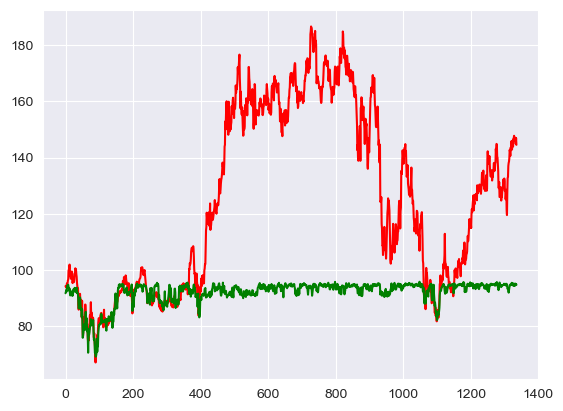

In [15]:
plt.plot(Y_test.values, label='Actual', color='red')
plt.plot(y_pred, label='RF Prediction', color='green')

In [16]:
model = XGBRegressor()

param_grid = {
    'objective': ['reg:squarederror'],
    'n_estimators': [50, 100, 150,200], 
    'max_depth': [3, 6, 10],         
    'learning_rate': [0.001, 0.01, 0.1,0,2, 0.3] 
}

tcv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tcv, n_jobs=-1)
grid_search.fit(X_train, Y_train)

grid_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [18]:
rfr_mse = mean_squared_error(Y_test, y_pred)
rfr_mae = mean_absolute_error(Y_test, y_pred)
rfr_r2 = r2_score(Y_test, y_pred)
print(f'XGB\n')
print(f'MSE: {rfr_mse}')
print(f'MAE: {rfr_mae}')
print(f'R2 : {rfr_r2}')

XGB

MSE: 2009.1108703197096
MAE: 33.47920196277367
R2 : -0.974718790833671


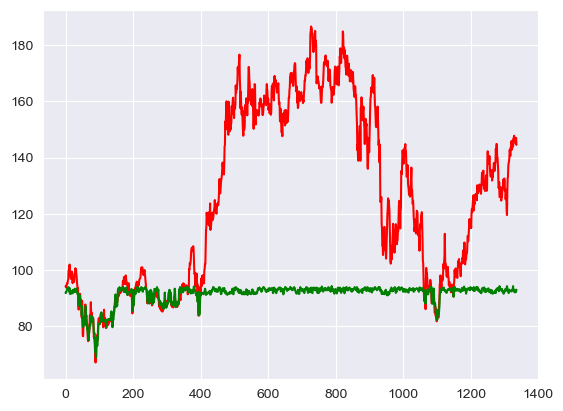

In [19]:
plt.plot(Y_test.values, label='Actual', color='red')
plt.plot(y_pred, label='RF Prediction', color='green')